In [15]:
import os
from typing import List, Tuple
from collections import namedtuple
from __future__ import absolute_import, print_function
from collections.abc import Sequence
from abc import ABCMeta, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import gym

In [9]:
Sample = namedtuple('Sample', ('state', 'action', 'reward', 'next_state'))

def toStr(sample):
    if not isinstance(sample, Sample):
        return sample
    vals = [sample.state, sample.action, sample.reward, sample.next_state]
    str_vals = [str(v) for v in vals]
    key_vals = ['state', 'action', 'reward', 'next_state']
    ret_str = ['(%s=%s)'%(k,v) for k,v in zip(key_vals, str_vals)]
    return '],['.join(ret_str)

In [11]:
class Episode(Sequence):
    def __init__(self, samples):
        for sample in samples:
            assert(isinstance(sample, Sample))

        self.samples = samples
        super(Episode, self).__init__()

    def __getitem__(self, item):
        return self.samples[item]

    def __len__(self):
        return len(self.samples)

    def __str__(self):
        return ' >,< '.join([toStr(sample) for sample in self.samples])

In [14]:
class ReinforcementLearner(object):
    __metaclass__ = ABCMeta

    @abstractmethod
    def fit(self, episodes):
        raise NotImplementedError("Subclass needs to implement")

    @abstractmethod
    def predict(self, curr_state):
        """
        Predict the next optimal action and total discounted reward starting from curr_state
        :param curr_state: np.ndarray containing a set of current states. Dimension: #batches X #features in a state
        :return Next optimal action and total discounted rewards for each batch
        """
        raise NotImplementedError("Subclass needs to implement")

In [16]:
class StateAndRewardEmulator(object):
    __metaclass__ = ABCMeta

    @abstractmethod
    def step(self, state, action):
        raise NotImplementedError("Subclass needs to implement")

    @abstractmethod
    def tfEnvStep(self, action: tf.Tensor) -> List[tf.Tensor]:
        raise NotImplementedError("Subclass needs to implement")

    def setInitialState(self, state):
        pass


class AIGymEmulator(StateAndRewardEmulator):
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.env.reset()

    def step(self, state, action):
        """ Returns next_state, reward, done, info """
        if (state is not None) and (np.equal(self.env.state, state).sum() != state.shape[0]):
            self.env.reset()
            self.env.state = self.env.unwrapped.state = state
        return self.env.step(action)

    def envStep(self, action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        state, reward, done, _ = self.env.step(action)
        return state.astype(np.float32), np.array(reward, dtype=np.float32), np.array(done, dtype=np.int32)

    # wrap open AI gym's env.step call as an operation in Tensorflow function to include in a callable TensorFlow graph
    def tfEnvStep(self, action: tf.Tensor) -> List[tf.Tensor]:
        """ Return next state, reward, done . Ignores the last info value """
        return tf.numpy_function(self.envStep, [action], [tf.float32, tf.float32, tf.int32])

In [17]:
class ACNetworkBase(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs: tf.Tensor, ** kwargs) -> Tuple[tf.Tensor, tf.Tensor]:
        raise NotImplementedError("Subclass needs to implement")

    def train(self, initial_state: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        raise NotImplementedError("Subclass needs to implement")

    def getExpectedReturns(self, rewards: tf.Tensor) -> tf.Tensor:
        """ Expected returns """
        ntime = tf.shape(rewards)[0]
        returns = tf.TensorArray(dtype=tf.float32, size=ntime)

        rewards = tf.cast(rewards[::-1], dtype=tf.float32)
        discounted_sum = tf.constant(0.0)
        discounted_sum_shape = discounted_sum.shape
        for i in tf.range(ntime):
            reward = rewards[i]
            discounted_sum = reward + self.discountFactor * discounted_sum
            discounted_sum.set_shape(discounted_sum_shape)
            returns = returns.write(i, discounted_sum)

        returns = returns.stack()[::-1]

        returns = ((returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + 1E-4))
        return returns


class ACNetwork(ACNetworkBase):
    """ Actor-Critic network with separate networks for actor and critic
    Critic produces state value function as output
    Actor is deterministic and produces the action
    """
    def __init__(self, actor_network, critic_network, emulator, discount_factor, max_steps_per_episode,
                 actor_optimizer, critic_optimizer):
        super().__init__()
        assert isinstance(emulator, StateAndRewardEmulator)
        self.actor = actor_network
        self.critic = critic_network
        self.emulator = emulator
        self.discountFactor = discount_factor
        self.maxStepsPerEpisode = max_steps_per_episode
        self.actorOptimizer = actor_optimizer
        self.criticOptimizer = critic_optimizer
        self.criticLoss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

    def call(self, inputs: tf.Tensor, **kwargs) -> Tuple[tf.Tensor, tf.Tensor]:
        return self.actor(inputs), self.critic(inputs)

    def train(self, initial_state: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        with tf.GradientTape() as critic_tape:
            with tf.GradientTape() as actor_tape:
                actions, values, rewards = self.runEpisode(initial_state)
                returns = self.getExpectedReturns(rewards)
                actions, values, returns = [tf.expand_dims(x, 1) for x in [actions, values, returns]]
                advantage = returns - values
                actor_loss = -tf.math.reduce_sum(advantage)
            critic_loss = self.criticLoss(values, returns)

        grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.criticOptimizer.apply_gradients(zip(grads, self.critic.trainable_weights))
        grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actorOptimizer.apply_gradients(zip(grads, self.actor.trainable_weights))
        episode_reward = tf.math.reduce_sum(rewards)
        return episode_reward, critic_loss + actor_loss

    def runEpisode(self, initial_state: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        state = initial_state
        self.emulator.setInitialState(initial_state)
        for t in tf.range(self.maxStepsPerEpisode):
            state = tf.expand_dims(state, 0)
            action, value = self.call(state)

            values = values.write(t, tf.squeeze(value))
            actions = actions.write(t, tf.squeeze(action))

            state, reward, done = self.emulator.tfEnvStep(action)
            rewards = rewards.write(t, reward)

            if tf.cast(done, tf.bool):
                break
        return actions.stack(), values.stack(), rewards.stack()


class CombinedACNetwork(ACNetworkBase):
    """ Combined actor critic network
    Actor and critic networks share common layers
    Critic network outputs one value: state value function
    Actor network outputs the probability (unnormalized) of each of a set of DISCRETE actions
    """
    def __init__(self, common_layers, actor_output_layer, critic_output_layer, emulator, discount_factor, optimizer,
                 max_steps_per_episode):
        super(CombinedACNetwork, self).__init__()
        assert isinstance(emulator, StateAndRewardEmulator)
        self.commonLayers = common_layers
        self.actor = actor_output_layer
        self.critic = critic_output_layer
        self.emulator = emulator
        self.discountFactor = discount_factor
        self.optimizer = optimizer
        self.criticLoss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
        self.maxStepsPerEpisode = max_steps_per_episode

    def call(self, inputs: tf.Tensor, **kwargs) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.commonLayers[0](inputs)
        for layer in self.commonLayers[1:]:
            x = layer(x)
        return self.actor(x), self.critic(x)

    def loss(self, action_probs: tf.Tensor, values: tf.Tensor, returns: tf.Tensor) -> tf.Tensor:
        """ combined actor-critic loss. returns is the target value """
        advantage = returns - values
        action_log_prob = tf.math.log(action_probs)
        actor_loss = -tf.math.reduce_sum(action_log_prob * advantage)
        critic_loss = self.criticLoss(values, returns)
        return actor_loss + critic_loss

    def runEpisode(self, initial_state: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

        state = initial_state
        self.emulator.setInitialState(state)
        for t in tf.range(self.maxStepsPerEpisode):
            state = tf.expand_dims(state, 0)
            action_logits_t, value = self.call(state)
            action = tf.random.categorical(action_logits_t, 1)[0, 0]
            action_probs_t = tf.nn.softmax(action_logits_t)

            values = values.write(t, tf.squeeze(value))
            action_probs = action_probs.write(t, action_probs_t[0, action])

            state, reward, done = self.emulator.tfEnvStep(action)
            rewards = rewards.write(t, reward)

            if tf.cast(done, tf.bool):
                break
        action_probs = action_probs.stack()
        values = values.stack()
        rewards = rewards.stack()
        return action_probs, values, rewards

    def train(self, initial_state: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        with tf.GradientTape() as tape:
            action_probs, values, rewards = self.runEpisode(initial_state)
            returns = self.getExpectedReturns(rewards)
            action_probs, values, returns = [tf.expand_dims(x, 1) for x in [action_probs, values, returns]]
            loss = self.loss(action_probs, values, returns)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        episode_reward = tf.math.reduce_sum(rewards)
        return episode_reward, loss


In [18]:
class AdvantageActorCriticLearner(ReinforcementLearner):
    """
    A2C learner. Needs a value function because it uses the policy being learned by actor.
    Batch A2:
    1. Sample {si, ai} from pi_theta(a|s)
    2. Fit value function V_phi_pi(s) to samples reward sums
    3. Calculate advantage: A_pi(si, ai) = r(si, ai) + gamma*V_phi_pi(s_i+1) - V_phi_pi(si)
    4. grad_theta(J(theta)) = sum_i(grad_theta log(pi_theta(ai|si) * A_pi(si, ai)
    5. theta += alpha * grad_theta J(theta)
    Online A2C:
    1. Take action a ~ pi_theta(a|s) to get (s, a, r, s')
    2. Update V_phi_pi(s) using target r + gamma * V_phi_pi(s')
    3. Calculate advantage: A_pi(si, ai) = r(si, ai) + gamma*V_phi_pi(s_i+1) - V_phi_pi(si)
    4. grad_theta(J(theta)) = sum_i(grad_theta log(pi_theta(ai|si) * A_pi(si, ai)
    5. theta += alpha * grad_theta J(theta)
    Handles the batch A2C version. Online version is a special case of batch version with batch size = 1
    """

    def __init__(self, ac_network, discrete_actions=True):
        """
        Initialize A2C learner
        :param ac_network: Actor-Critic network. Must be an instance of ACNetworkBase
        :param discrete_actions: Is action space discrete?
        """
        assert isinstance(ac_network, ACNetworkBase)
        self.acNetwork = ac_network
        self.discreteActions = discrete_actions

    def fit(self, episodes: list) -> pd.DataFrame:
        assert len(episodes)
        nelements = sum([len(ep) for ep in episodes])
        rewards = np.zeros(nelements, dtype=np.float32)
        losses = np.zeros(nelements, dtype=np.float32)
        assert isinstance(episodes[0], Episode)
        count = 0
        for episode in episodes:
            for initial_sample in episode:
                state, action, reward, next_state = initial_sample
                initial_state = tf.constant(state, dtype=tf.float32)
                episode_reward, loss = self.acNetwork.train(initial_state)
                rewards[count] = episode_reward.numpy()
                losses[count] = loss.numpy()
                count += 1

        return pd.DataFrame({"rewards": rewards, "loss": losses})

    def predict(self, curr_state):
        assert len(curr_state.shape) == 1
        state = tf.constant(curr_state[np.newaxis, :], dtype=tf.float32)
        action_logits_t, value = self.acNetwork.call(state)
        if self.discreteActions:
            action = tf.math.argmax(action_logits_t, axis=1)
            return action.numpy()[0], value.numpy()[0, 0]
        return action_logits_t.numpy()[0, :], value.numpy()[0, 0]

Actor-Critic: final PNL: 2.615519, SR: 1.070670
Buy-and-hold: final PNL: 2.189868, SR: 0.747095


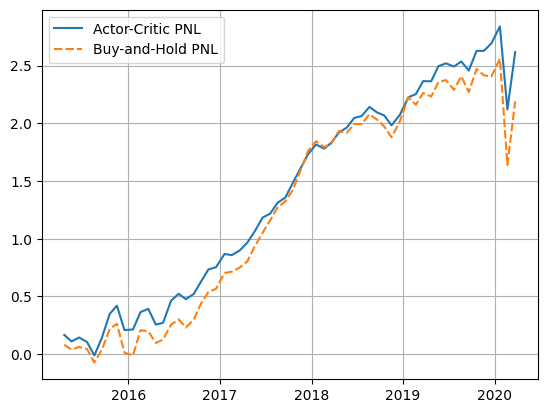

In [8]:
class PortfolioEmulator(StateAndRewardEmulator):
    def __init__(self, dfs, var, covar, trx_cost, price_col, return_col, max_days, nstocks):
        self.dfs = dfs
        self.nStock = nstocks
        self.var = var
        self.covar = covar
        self.iVar = 0
        self.iCvar = nstocks
        self.iRet = nstocks + nstocks*(nstocks - 1) // 2
        self.iWeight = self.iRet + nstocks
        self.priceCol = price_col
        self.retCol = return_col
        self.trxCost = trx_cost
        self.maxDays = max_days
        self._begin = 0
        self._index = 0
        self._state = None

    def step(self, state, action):
        pass

    def setInitialState(self, state):
        self._state = state

    def setBeginIndex(self, value):
        self._begin = value
        self._index = value

    def getReward(self, state, action, index, begin):
        weights = state[self.iWeight:]
        begin_price = np.array([df.loc[begin, self.priceCol] for df in self.dfs])
        price = np.array([df.loc[index, self.priceCol] for df in self.dfs])
        if index - begin == self.maxDays:
            nshares = np.divide(weights, begin_price) * self.nStock
            pnl = (1 - self.trxCost) * np.sum(nshares * price)
        else:
            new_position = action
            pos_change = new_position - weights
            nshares = np.divide(pos_change, begin_price) * self.nStock
            price_change = np.array(
                [df.loc[index, self.priceCol] - df.loc[index - 1, self.priceCol] for df in self.dfs])
            pnl = np.sum(price_change * nshares) - self.trxCost * np.sum(nshares * price)

        return pnl

    def tfEnvStep(self, action: tf.Tensor) -> List[tf.Tensor]:
        self._index += 1
        index = self._index
        action = tf.squeeze(action)
        weights = self._state[self.iWeight:]
        price = [df.loc[index, self.priceCol] for df in self.dfs]
        done = False
        if index - self._begin == self.maxDays:
            pnl = (1 - self.trxCost) * tf.reduce_sum(weights * price)
            self._begin += 1
            self._index = self._begin
            done = True
        else:
            new_position = action
            pos_change = new_position - weights
            price_change = [df.loc[index, self.priceCol] - df.loc[index - 1, self.priceCol] for df in self.dfs]
            pnl = tf.reduce_sum(price_change * pos_change) - self.trxCost * tf.reduce_sum(pos_change * price)

        new_cvar = self.covar[index, :]
        new_var = self.var[index, :]
        new_ret = [df.loc[index, self.retCol] for df in self.dfs]
        next_state = tf.concat((new_var, new_cvar, new_ret, action), axis=0)
        self._state = next_state
        return [next_state, pnl, done]


class PortOptim(object):
    def __init__(self, stocks, inputdir, transaction_cost, training_data=0.75):
        self.stocks = stocks
        self.transactionCost = transaction_cost
        self.nStock = len(stocks)
        self.holdingPeriod = 21
        self.dfs = []
        self.priceCol = "Adj Close"
        self.dateCol = "Date"
        self.returnCol = "daily_return"

        for stock in stocks:
            filename = os.path.join(inputdir, "%s.csv" % stock)
            df = pd.read_csv(filename, parse_dates=[self.dateCol])
            df = self.calculateReturns(df)
            self.dfs.append(df)

        dates = self.dfs[0].loc[:, self.dateCol]
        self.nDate = dates.shape[0]
        for i in range(1, self.nStock):
            self.dfs[i] = pd.merge(dates, self.dfs[i], on=[self.dateCol], how="left")
        self.nTrain = int(training_data * self.dfs[0].shape[0])
        self.var, self.covar = self.calculateCovar()
        self.emulator = PortfolioEmulator(self.dfs, self.var, self.covar, self.transactionCost,
                                          self.priceCol, self.returnCol, self.holdingPeriod, self.nStock)
        self.acnet = self.createActorCritic()
        self.aclearner = AdvantageActorCriticLearner(self.acnet, discrete_actions=False)

    def calculateReturns(self, df: pd.DataFrame) -> pd.DataFrame:
        # 2 day return
        price = df.loc[:, self.priceCol].values
        df.loc[:, self.returnCol] = 0.0
        logPrice = np.log(price)
        logPriceDiff = logPrice[2:] - logPrice[0:-2]
        df.loc[3:, self.returnCol] = logPriceDiff[0:-1]
        return df

    def calculateCovar(self) -> Tuple[np.ndarray, np.ndarray]:
        dfs = self.dfs
        variances = np.zeros((self.nDate, self.nStock), dtype=np.float32)

        for index, df in enumerate(dfs):
            ret = df.loc[:, self.returnCol].values
            var = variances[:, index]
            sum_val = np.sum(ret[2:2+self.holdingPeriod])
            sumsq_val = np.sum(ret[2:2+self.holdingPeriod] * ret[2:2+self.holdingPeriod])
            mean_val = sum_val / self.holdingPeriod
            var[2+self.holdingPeriod-1] = sumsq_val / self.holdingPeriod - mean_val * mean_val
            for i in range(2+self.holdingPeriod, var.shape[0]):
                sum_val += ret[i] - ret[i-self.holdingPeriod]
                sumsq_val += ret[i] * ret[i] - ret[i-self.holdingPeriod] * ret[i-self.holdingPeriod]
                mean_val = sum_val / self.holdingPeriod
                var[i] = sumsq_val / self.holdingPeriod - mean_val * mean_val

        ncvar = self.nStock * (self.nStock - 1) // 2
        covar = np.zeros((self.nDate, ncvar), dtype=np.float32)
        count = 0

        for i1 in range(self.nStock):
            ret1 = self.dfs[i1].loc[:, self.returnCol].values
            for j in range(i1+1, self.nStock):
                ret2 = self.dfs[j].loc[:, self.returnCol].values
                cvar = covar[:, count]
                for i in range(2 + self.holdingPeriod, cvar.shape[0]):
                    begin = i - self.holdingPeriod
                    sum_val1 = np.sum(ret1[begin:begin + self.holdingPeriod])
                    sum_val2 = np.sum(ret2[begin:begin + self.holdingPeriod])
                    mean_val1 = sum_val1 / self.holdingPeriod
                    mean_val2 = sum_val2 / self.holdingPeriod
                    sumprod = np.sum((ret1[begin:i] - mean_val1) * (ret2[begin:i] - mean_val2))
                    cvar[i] = sumprod / (self.holdingPeriod * variances[i, i1] * variances[i, j])

                count += 1

        # calculate variance ratio
        variances[2+self.holdingPeriod+1:-1, :] = np.divide(variances[2+self.holdingPeriod+1:-1, :],
                                                            variances[2+self.holdingPeriod:-2, :])

        return variances, covar

    def createActorCritic(self):
        value_network = tf.keras.models.Sequential()
        # state: variance, cvar, ret, stock weights
        ninp = self.nStock + self.nStock*(self.nStock-1)//2 + self.nStock + self.nStock
        value_network.add(tf.keras.layers.Dense(4, input_shape=(ninp,)))
        value_network.add(tf.keras.layers.Dense(10, activation="relu"))
        value_network.add(tf.keras.layers.Dense(1))

        anet = tf.keras.models.Sequential()
        anet.add(tf.keras.layers.Dense(4, input_shape=(ninp,)))
        anet.add(tf.keras.layers.Dense(10, activation="relu"))
        anet.add(tf.keras.layers.Dense(self.nStock, activation="sigmoid"))
        anet.add(tf.keras.layers.Softmax())

        actor_optim = tf.keras.optimizers.Adam()
        critic_optim = tf.keras.optimizers.Adam()

        return ACNetwork(anet, value_network, self.emulator, 1.0, self.holdingPeriod, actor_optim, critic_optim)

    def randomAction(self):
        wts = np.random.random(self.nStock)
        return np.divide(wts, wts.sum())

    def getInitialWeights(self, day):
        wts = [1.0/df.loc[day, self.priceCol] for df in self.dfs]
        return np.divide(wts, np.sum(wts))

    def generateTrainingEpisodes(self):
        episodes = []
        samples = [None]
        begin = 0

        for i in range(2 + self.holdingPeriod, self.nTrain - self.holdingPeriod):
            curr_weights = self.getInitialWeights(begin)
            rets = [df.loc[i, self.returnCol] for df in self.dfs]
            state = np.concatenate((self.var[i, :], self.covar[i, :], rets, curr_weights))
            action = self.randomAction()
            reward = self.emulator.getReward(state, action, i, begin)
            if i - begin == self.holdingPeriod:
                begin = i
            samples[0] = Sample(state, action, reward, None)
            episode = Episode(samples)
            episodes.append(episode)

        return episodes

    def train(self):
        # create episodes for training
        episodes = self.generateTrainingEpisodes()
        self.emulator.setBeginIndex(2+self.holdingPeriod)
        self.aclearner.fit(episodes)

    def actorCriticPnl(self, day):
        pnl = -self.nStock
        wts = np.full(self.nStock, 1.0/self.nStock, dtype=np.float32)
        for i in range(day+1, day+self.holdingPeriod+1):
            new_cvar = self.covar[i-1, :]
            new_var = self.var[i-1, :]
            new_ret = [df.loc[i-1, self.returnCol] for df in self.dfs]
            state = np.concatenate((new_var, new_cvar, new_ret, wts))
            vals = self.aclearner.predict(state)
            abs_change = np.sum(np.abs(wts - vals[0]))
            if abs_change > 0.1:
                wts[:] = vals[0]
            pnl += self.emulator.getReward(state, wts, i, day)
        return pnl

    def buyAndHoldPnl(self, day):
        nstocks = [1.0 / df.loc[day, self.priceCol] for df in self.dfs]
        price = [df.loc[day+self.holdingPeriod, self.priceCol] for df in self.dfs]
        return -self.nStock + (1 - self.transactionCost) * np.sum(np.multiply(price, nstocks))

    def test(self):
        pnl_data = []
        pnl_bh_data = []
        pnl_diff = []
        dates = []
        self.emulator.setBeginIndex(self.nTrain)
        for i in range(self.nTrain, self.nDate-self.holdingPeriod-2, self.holdingPeriod):
            pnl = self.actorCriticPnl(i)
            pnl_bh = self.buyAndHoldPnl(i)
            pnl_diff.append(pnl - pnl_bh)
            pnl_data.append(pnl)
            pnl_bh_data.append(pnl_bh)
            dates.append(self.dfs[0].loc[i, self.dateCol])


        perf_df = pd.DataFrame(data={"Actor-Critic PNL": np.cumsum(pnl_data),
                                     "Buy-and-Hold PNL": np.cumsum(pnl_bh_data)},
                               index=np.array(dates))
        final_pnl = np.array([np.sum(pnl_data), np.sum(pnl_bh_data)])
        mean_pnl = np.array([np.mean(pnl_data), np.mean(pnl_bh_data)])
        sd_pnl = np.array([np.std(pnl_data), np.std(pnl_bh_data)])
        sr = np.sqrt(252.0/self.holdingPeriod) * mean_pnl/sd_pnl
        print("Actor-Critic: final PNL: %f, SR: %f" % (final_pnl[0], sr[0]))
        print("Buy-and-hold: final PNL: %f, SR: %f" % (final_pnl[1], sr[1]))
        sns.lineplot(data=perf_df)
        plt.grid(True)
        plt.show()


if __name__ == "__main__":
    stocks = ["MSFT", "BA"]
    inputdir = r"/content/RLproject/price/"
    portopt = PortOptim(stocks, inputdir, 0.001)
    portopt.train()
    portopt.test()